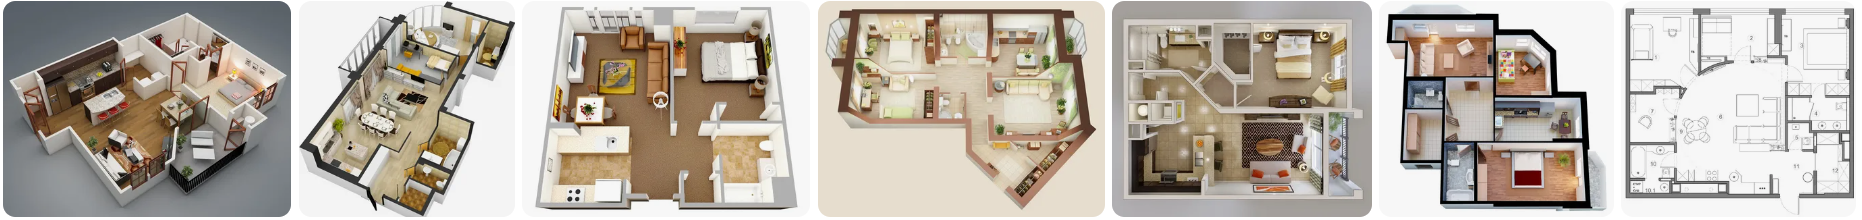

# Исследование объявлений о продаже квартир

**Цель исследования:** определить уровень влияния характеристик объектов недвижимости на стоимость этих объектов.

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Требуется провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Проверить гипотезы:
1) на стоимость значительно влияет общая площадь, тип этажа (1-ый/последний), близость к центру, близость к паркам/водоёмам, социальная инфраструктура (школы, садики, больницы), экологическая обстановка (ближайшие промзоны, уровень загрязнения воздуха), криминогенность района, близость к метро, плотность застройки, наличие парковочных мест, год постройки;\
2) самая дорогая недвижимость (цена кв.м) в Санкт-Петербурге. <br><br>
**Ход исследования:**
1) обзор данных;\
2) предобработка данных;\
3) исследование данных, проверка гипотез.

## Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import re

In [2]:
try:
    data = pd.read_csv('../../03 исследовательский анализ данных/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data',sep='\t')

In [3]:
pd.set_option('display.max_columns', None) # для вывода всех столбцов df на экран

In [4]:
data.head() # первые 5 строк df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info() # общая информация o df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Замечания по общим данным:**
* first_day_exposition - тип object, лучше переделать в datetime;
* floors_total, balcony, days_exposition - тип float, лучше переделать в int;
* is_apartment - тип object, лучше переделать в bool;
* cityCenters_nearest - можно убрать большую букву (а можно и не убирать);
* много пропусков, необходимо заполнить/удалить/не изменять.


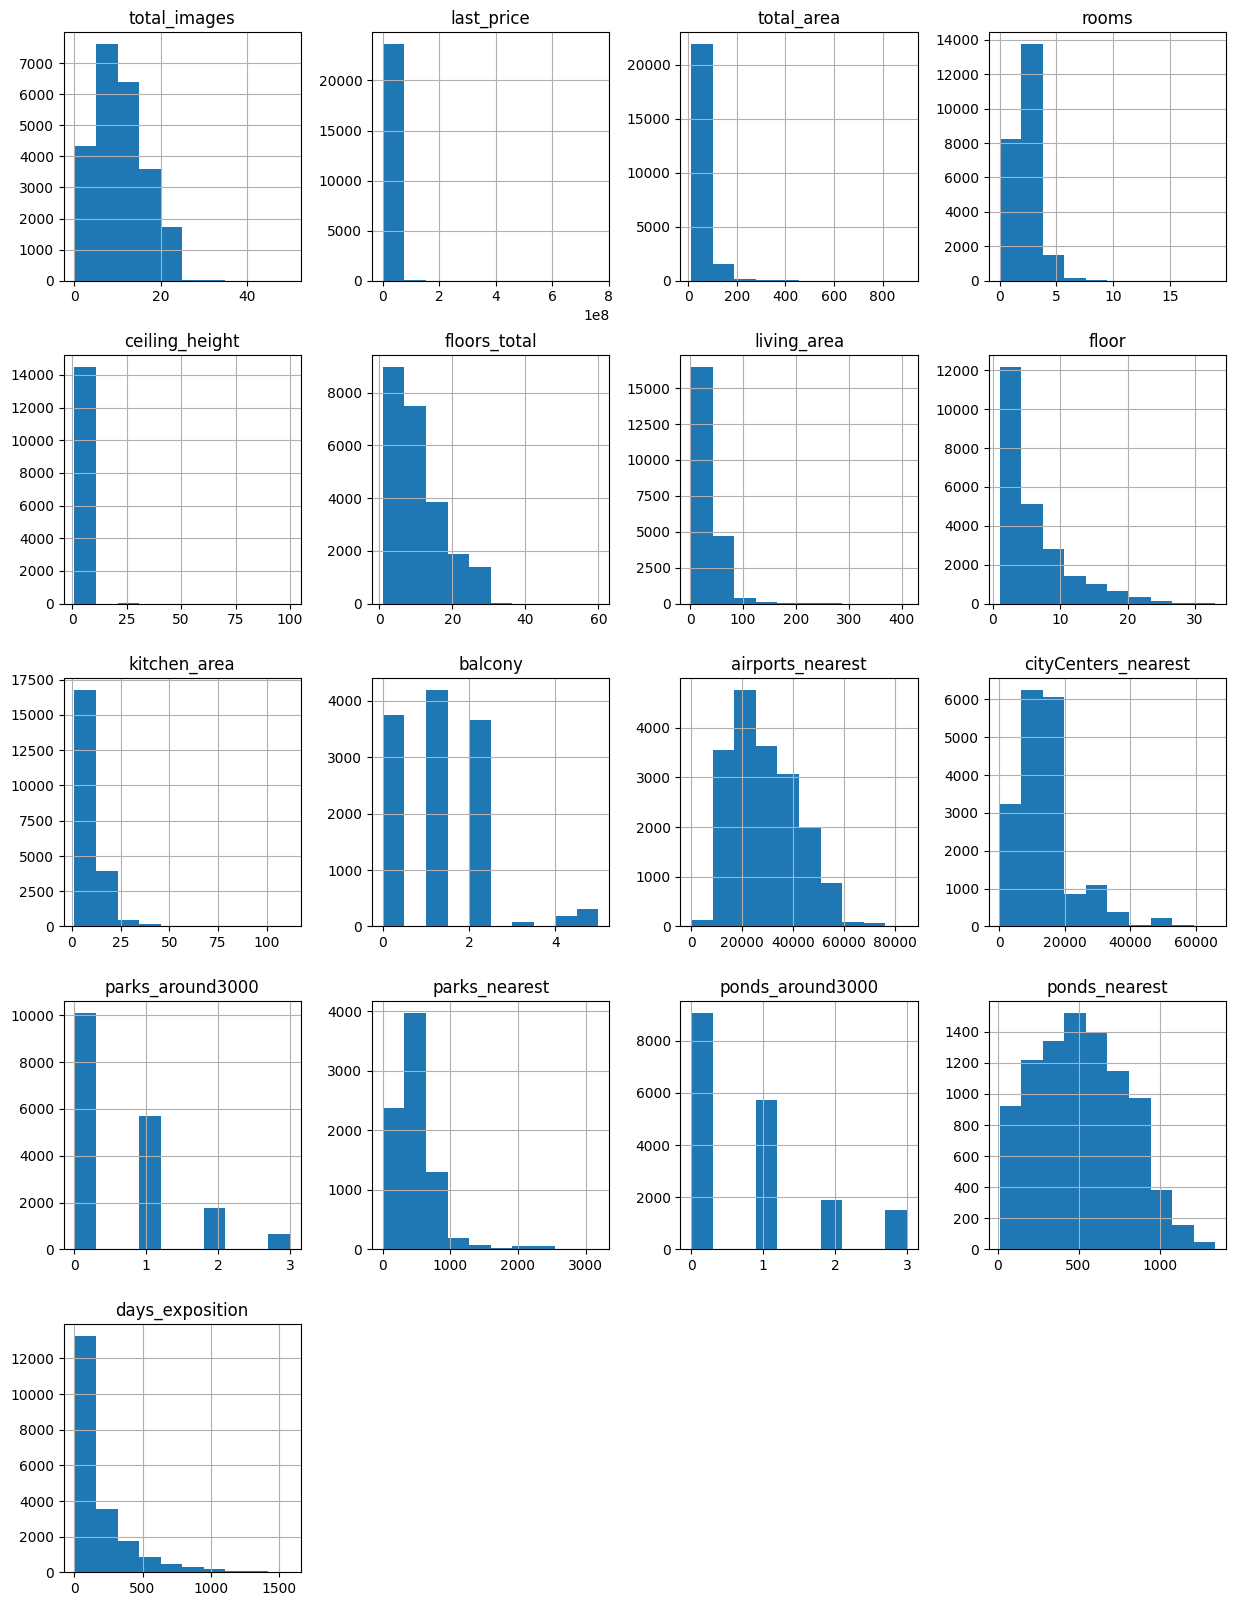

In [6]:
data.hist(figsize=(15,20))        # строим гистограммы по каждому числовому параметру
plt.show()                        # метод убирает лишнюю информацию над графиками

**Замечания по гистограммам:**
* last_price, total_area, rooms, ceiling_height, floors_total, living_area, kitchen_area - скорее всего есть единичные выбросы, непозволяющий увидеть гистограммы в основном массовом диапазоне; необходимо понять достоверность данного выброса; если это ошибочные значения - обработать;
* balcony - подозрительно кол-во балконов от трёх и больше;
* cityCenters_nearest - подозрительный отдельный выступ на 50000 м; возможно это маленький город в пригороде СПБ.


## Предобработка данных

### Поиск пропущенных значений

In [7]:
data_nan_before = \
 (pd.DataFrame(data.isna().sum(), columns=['sum_nun_before']).join                            # сумма пропущенных значений
 (pd.DataFrame(data.isna().apply(lambda x: round(x.mean()*100)),columns=['%_nun_before'])))   # % пропущенных значений
data_nan_before.style.background_gradient('coolwarm')

,sum_nun_before,%_nun_before
total_images,0,0
last_price,0,0
total_area,0,0
first_day_exposition,0,0
rooms,0,0
ceiling_height,9195,39
floors_total,86,0
living_area,1903,8
floor,0,0
is_apartment,20924,88


**ceiling_height** - много пропусков; вероятно из-за того, что продавцы не знают высоту и ленятся измерять; удалять строки нельзя, т.к. можем удалить важную информацию из других столбцов; менять не можем, т.к. это будет гадание без фактов

**balcony** - много пропусков; вероятно подразумевается отсутствие балкона; заполним пропуски нулями:

In [8]:
data['balcony'] = data['balcony'].fillna(0)

**kitchen_area** - можно предположить, что пропуски соответствуют студиям. Также проверим, какая площадь кухонь указана в студиях обычно (может помимо NaN есть значения).

In [9]:
data['studio'].value_counts()

False    23550
True       149
Name: studio, dtype: int64

In [10]:
data[data['studio']==True]['kitchen_area'].unique()

array([nan])

Во всех 149 студиях отсутствует значение площади кухни. Заполним площадь кухни в студиях нулями.

In [11]:
data.loc[data['studio']==True,'kitchen_area'] = 0

Обработаем оставшиеся пропуски в столбцах с площадью:

In [12]:
data[['total_area','living_area','kitchen_area']].isna().sum()

total_area         0
living_area     1903
kitchen_area    2129
dtype: int64

**living_area** + **kitchen_area** = total_area. Это допущение. Пренебрежём площадью коридора и санузла. Во-перых, доля данных которые мы собираемся так заполнить 5%. Во-вторых, доля коридора и санузла в общей площади около 10%. Таким образом заполнение пропущенных значений по указанному принципу будет достаточно точным и возможная погрешность не повлияет на общие закономерности.

In [13]:
#количество ячеек, которое мы сможем заполнить с помощью логического оператора "исключающее ИЛИ":
data[(data['living_area'].isna()) ^ (data['kitchen_area'].isna())].shape[0]

1124

In [14]:
#заполним пропуски жилых площадей (общая площадь - площадь кухни):
data.loc[(data['living_area'].isna()) & (~data['kitchen_area'].isna()),'living_area'] = \
data['total_area'] - data['kitchen_area']

In [15]:
#заполним пропуски кухонных площадей (общая площадь - жилая площадь):
data.loc[(~data['living_area'].isna()) & (data['kitchen_area'].isna()),'kitchen_area'] = \
data['total_area'] - data['living_area']

Для заполнения оставшихся пропусков в столбцах с площадью у нас нет данных. Возможные причины отсутствия информации: продавец не владел данными, технический сбой электронной базы.

**floors_total** - меньше процента кол-во пропусков; проверим предположение, что это одноэтажные частные дома; если подтвердится проставим в пропусках 1; посмотрим этажность квартиры в строках с неизвестной этажностью дома.

In [16]:
data.query('floors_total.isna()')['floor'].unique()

array([ 4,  1, 12,  8,  9, 22, 15,  6,  7,  3, 18, 13, 24, 21, 11,  2,  5,
       19, 20, 14, 17, 23, 10], dtype=int64)

Предположение по причине пропусков в floors_total не подтвердилось. Дома многоэтажные. Оставляем пропуски. Причина возникновения: не заполнение продавцом или технический сбой.

<a id='2.1.++'></a>
**is_apartment** - большинство ячеек не заполнено. Предположения: 1)продавцы точно не знают критерии отнесения к апартаментам; 2)характеристика появилась недавно, значительно позднее размещения основной массы объявлений.
Оставляем пропуски незаполненными. \
**locality_name** - пропусков меньше процента. Косвенные призначки для идентификации отсутствуют. Не заполняем. Причина пропуска: опечатка продавца (не заметил графу для заполнения), технический сбой.

**airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000** - одинаковый процент пропусков (23%); изучим, есть ли связь между характеристиками, одни ли это строки.

In [17]:
# количество строк с пропусками одновременно в 4-ёх столбцах
data.query('airports_nearest.isna() and cityCenters_nearest.isna() and ponds_around3000.isna() and parks_around3000.isna()') \
.shape[0]

5518

Это одни и те же строки. Запомним для себя выше отфильтрованный df под именем его длины - "5518".
Вероятно недвижимость в небольших населённых пунктах.
Посмотрим сколько объектов недвижимости из данных 5518 строк в Санкт-Петербурге:

In [18]:
data.query('airports_nearest.isna() and cityCenters_nearest.isna() and ponds_around3000.isna() and parks_around3000.isna()')\
['locality_name'].isin(['Санкт-Петербург']).sum()

61

<a id='duplicates'></a>
В Санкт-Петербурге 1% объектов недвижимости из отобранных 5518 строк. 
Обработаем уникальные значения в locality_name, уберём неявные дубликаты.     Создадим дополнительный столбец с названиями населённых пунктов без указания типа. Выведем уникальные значения чтобы увидеть есть ли схожие названия, нет ли опечаток.

In [19]:
# убираем тип населённого пункта и пробелы перед названием нас.п.
def short_name (i):
    try:
        res1 = re.sub('посёлок|поселок|деревня|село|городской|типа|имени|садоводческое|некоммерческое|товарищество|коттеджный|при железнодорожной|станции|городского|садовое','',i)
        return re.sub('^\s+','',res1)
    except:
        return float('nan')
data['locality_name_short'] = data['locality_name'].apply(short_name)
data.sort_values('locality_name_short')['locality_name_short'].unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жил', 'Жилгородок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара', 'Ильи

<a id='2.1.+'></a>
Опечаток нет. Вероятно в каких-то строках data с необходимым насел.пунктом есть заполненные данные по обсуждаемым 4 столбцам. Поскольку для областных населённых пунктов небольшого размера рассматриваемые 4 характеристики будут практически идентичны, мы сможем заполнить пропуски в этих 4-х характеристиках медианным значением по конкретному нас. п. (кроме СПБ, т.к. он большой).

In [20]:
#сохраним список населённых п. из df "5518" за исключением СПБ
list_name_5518 = list(data.query('airports_nearest.isna() and cityCenters_nearest.isna() and \
                                  ponds_around3000.isna() and parks_around3000.isna()    and \
                                  locality_name_short != "Санкт-Петербург"')['locality_name_short'].unique())
len(list_name_5518) # число населённых пунктов в списке "5518" за исключением СПБ

286

In [21]:
#сформируем df на основе data из медианных значений 4-х обсуждаемых столбцов, но только с нас.пунктами из "5518"
data_name_median = data.query('locality_name_short in @list_name_5518')\
                   [['airports_nearest','cityCenters_nearest','ponds_around3000','parks_around3000','locality_name_short']]\
                   .pivot_table(index='locality_name_short',aggfunc=['median'])
#заменим мультииндекс в названии колонок одинарным индексом
data_name_median.columns = ['airports_nearest','cityCenters_nearest','parks_around3000','ponds_around3000']
data_name_median

,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000
locality_name_short,,,,
Колпино,26232.0,32018.0,0.0,1.0
Красное Село,25715.5,29140.5,0.0,0.0
Кронштадт,67850.0,49575.0,2.0,2.0
Ломоносов,48415.5,51677.0,0.0,1.0
Мурино,51553.0,21888.0,0.0,2.0
Шушары,17427.0,24212.0,0.0,0.0
Щеглово,61908.0,34085.0,0.0,0.0


Таким образом у нас есть данные по 7 нас.пунктам (из желаемых 286). Заполним пропуски в data по 4-ём столбцам по 7-ми населённым пунктам:

In [22]:
#с помощью двойного цикла обходим все ячейки data_name_median, берём значения и присваиваем их соответствующим ячейкам data
for i in data_name_median.index:
    for j in data_name_median:
        data.loc[(data[j].isna()) & (data['locality_name_short'] == i), j] = data_name_median.loc[i,j]

Данными действиями мы уменьшили число пропусков в data в обсуждаемых 4-ёх столбцах с 23 до 21%.

**parks_nearest, ponds_nearest** - много пропусков. Вероятно, большая часть пропусков свидетельствует об отсутствии парка/пруда в пределах 3000м. Заполнять такие пропуски не имеет смысла. Возможно также есть пересечения параметров с количеством парков/прудов>0 и с неуказанным расстоянием до ближайшего (NaN). Получается парк/пруд точно находится в пределах 3000м. Можно было бы заполнить в этих случаях расстояние до парка/пруда значением "3000", но это было бы не точно. Заполнять не будем. Просто оценим количество таких строк.

In [23]:
#количество пересечений по паркам
data.query('parks_nearest.isna() & parks_around3000>0').shape[0]

1

In [24]:
#количество пересечений по прудам
data.query('ponds_nearest.isna() & ponds_around3000>0').shape[0]

591

**days_exposition** - 13% пропусков. Вероятно причина техническая. Необходимо выяснять у коллег, как определяется диапазон расчёта. Например, может быть параметр не рассчитывается, если объявление в момент выгрузки данных ещё было размещено.  Заполнять не можем.

In [25]:
#сравнение кол-ва пропусков до/после обработки
data_nan_after1 = \
 (pd.DataFrame(data.isna().sum(), columns=['sum_nun_after1']).join                            # сумма пропущенных значений
 (pd.DataFrame(data.isna().apply(lambda x: round(x.mean()*100)),columns=['%_nun_after1'])))   # % пропущенных значений

data_nan_before.join(data_nan_after1)

,sum_nun_before,%_nun_before,sum_nun_after1,%_nun_after1
total_images,0,0,0,0
last_price,0,0,0,0
total_area,0,0,0,0
first_day_exposition,0,0,0,0
rooms,0,0,0,0
ceiling_height,9195,39,9195,39
floors_total,86,0,86,0
living_area,1903,8,1454,6
floor,0,0,0,0
is_apartment,20924,88,20924,88


### Преобразование типов данных <a id='2.2.'></a>

**first_day_exposition** - из object делаем datetime. Удобный формат для работы со временем. Можно будет вычленять отдельные элементы даты и прибавлять/вычитать дни (при необходимости).

In [26]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

<a id='2.2.преобразование_типов'></a>
**floors_total, balcony, days_exposition** - из float делаем int. Характеристики не имеют логики в дробном виде. Меньшее кол-во информации (без нулей после запятой) проще воспринимать. \
**is_apartment** - тип object с элементами классов bool и float; не трогаем.

In [27]:
data['balcony'] = data['balcony'].astype('Int64',errors='ignore')
data['days_exposition'] = data['days_exposition'].astype('Int64',errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           22245 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          22245 non-null  float64       
 13  balcony         

'days_exposition' не преобразовалось в тип Int64. Вероятно, есть дробные значения. Изучим.

In [28]:
de = data['days_exposition']%data['days_exposition'].round() # выделяем дробный остаток
de[~de.isna()].unique()

array([0.00000000e+00, 2.84217094e-14, 1.42108547e-14, 5.68434189e-14,
       1.13686838e-13, 8.88178420e-16, 7.10542736e-15, 1.77635684e-15,
       3.55271368e-15, 4.44089210e-16, 2.27373675e-13])

Предположение подтвердилось. Округлим характеристику. После преобразуем в Int64.

In [29]:
data['days_exposition'] = data['days_exposition'].round().astype('Int64',errors='ignore')

#### Удалим явные дубликаты (при их наличии)

In [30]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют. \
Неявные дубликаты в locality_name были обработаны [выше](#duplicates) и создан столбец с однозначными значениями населённых пунктов locality_name_short.

### Обработка редких и выбивающихся значений

In [31]:
data.describe() #описание числовых столбцов для оценки выбивающихся значений

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,22245.000000,23699.000000,22245.000000,23699.000000,18777.000000,18800.000000,18801.000000,8079.000000,18801.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.905587,5.892358,10.804370,0.591080,29547.179555,14464.889840,0.591352,490.804555,0.807617,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,23.113415,4.885249,6.849086,0.959298,13091.931793,8609.643055,0.796313,342.317995,0.947818,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.800000,2.000000,7.000000,0.000000,18771.000000,9461.750000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.010000,4.000000,9.200000,0.000000,27286.000000,13279.000000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.800000,8.000000,12.000000,1.000000,38817.000000,16787.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,571.000000,33.000000,230.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Из представленных выше 17-ти числовых характеристик подозрение вызывают 6:

**ceiling_height** - большой разброс. Гипотезы отклонения:
- (<2) - ошибка или нежилое помещение (гараж, склад, погреб, чердак);
- [2-3.5) - норма;
- [3.5-10) - возможно изредка для дорогой недвижимости (дворцы, музеи, офисы);
- [10-20) - ошибка заполнения;
- [20<) - вероятно опечатка или техническая ошибка (лишний ноль).

In [32]:
data.query('ceiling_height<2').shape[0] #кол-во объектов недвижимости с высотой потолка до 2м

3

In [33]:
data.loc[data['ceiling_height']<2,'ceiling_height'] = float('NaN') #удаляем информацию из трёх ячеек со слишким низким потолком

In [34]:
data.query('2 <= ceiling_height < 3.5').shape[0] #кол-во объектов недвижимости с высотой потолка от 2 до 3 м; норма; не изменяем

14067

In [35]:
data.query('3.5 <= ceiling_height < 10').shape[0] #кол-во объектов недвижимости с высотой потолка от 3.5 до 10 м; норма для топ

409

In [36]:
data.query('10 <= ceiling_height < 20').shape[0] #кол-во объектов недвижимости с высотой потолка от 10 до 20 м

2

In [37]:
data.query('10 <= ceiling_height < 20') #объекты с высотой потолка от 10 до 20м

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14.0,32.4,5,NaN,False,False,9.1,2,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315,Санкт-Петербург
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16.0,15.5,15,NaN,False,False,29.5,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136,Санкт-Петербург


Объект с высотой 14.0 - вероятно ошибка; число скопировано из floors_total.\
Объект с высотой 10.3 - вероятно ошибка.

In [38]:
#удаляем информацию из двух ячеек со странными большими значениями от 10 до 20 м
data.loc[(10<=data['ceiling_height']) & (data['ceiling_height']<20),'ceiling_height'] = float('NaN')

In [39]:
data.query('20 <= ceiling_height').value_counts('ceiling_height') #количество уникальных значений высот потолков выше 20м

ceiling_height
27.0     8
25.0     7
32.0     2
20.0     1
22.6     1
24.0     1
26.0     1
27.5     1
100.0    1
dtype: int64

In [40]:
data.query('ceiling_height == 100') # присмотримся к объекту с высотой 100

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5.0,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19,Санкт-Петербург


Объект с высотой 100, вероятно, полностью ошибочный. Странные характеристики помимо высоты: общая площадь 25м, 1 комната, 5 балконов.

In [41]:
data = data.query('ceiling_height!=100') #удаляем объект с высотой потолка 100

Объекты с высотами от 20 до 32 м, вероятно прописаны с опечаткой. Корректная высота в 10 раз меньше.

In [42]:
#делим на 10 все значения высот больше 20
data.loc[20 <= data['ceiling_height'],'ceiling_height'] = data.loc[20 <= data['ceiling_height'],'ceiling_height']/10

In [43]:
print(data['ceiling_height'].min(),"-", data['ceiling_height'].max()) #диапазон высот потолков после обработки

2.0 - 8.3


**last_price** - проверим минималные и максимальные значения

In [44]:
data.sort_values('last_price').head() #первые 5 объектов с минимальной ценой

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8,Санкт-Петербург
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,NaN,False,False,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,Сланцы
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,NaN,3,NaN,False,False,NaN,0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44,Свирь
16274,18,440000.0,40.0,2018-07-10,1,NaN,5.0,NaN,1,NaN,False,False,NaN,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45,Старополье
17676,0,450000.0,36.5,2018-02-01,1,NaN,5.0,17.3,4,NaN,False,False,8.5,1,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120,Ям-Тесово


12190 - явно кратно выбивается. Вероятно не хватает некоторого количества нулей. Проверим медианную цену в СПБ у квартир схожей площади:

In [45]:
data.query('100<total_area<120 and locality_name_short=="Санкт-Петербург"')['last_price'].median()

12800000.0

In [46]:
#дописываем 3 нуля к цене выбивающегося объекта
data.loc[data['last_price']==12190,'last_price'] = 12190000

In [47]:
data.sort_values('last_price').tail() #последние 5 объектов с максимальной ценой

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7.0,258.0,5,NaN,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111,Санкт-Петербург
1436,19,330000000.0,190.0,2018-04-04,3,3.5,7.0,95.0,5,NaN,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233,Санкт-Петербург
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9.0,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393,Санкт-Петербург
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,NaN,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106,Санкт-Петербург
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10.0,250.0,10,NaN,False,False,150.0,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33,Санкт-Петербург


Единичных выбросов нет. Посмотрим медианную цену со схожей и большей площадью:

In [48]:
data.query('350<total_area<900 and locality_name_short=="Санкт-Петербург"')['last_price'].median()

65000000.0

Медианная цена недвижимости схожей (и большей) площади в 10 раз ниже цены самого дорого объекта. Подозрительно. Но менять цену не будем из-за недостаточности доказательств. Возможно другие факторы так повлияли на цену этого самого дорогого объекта. А может быть владелец и не планировал его продавать, а просто приценивался.

**total_area** - посмотрим минимальные и максимальные значения

In [49]:
data.sort_values('total_area').head() # 5 объектов с минимальной площадью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5.0,10.0,2,NaN,False,False,2.0,0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200,Санкт-Петербург
19807,0,3800000.0,13.0,2018-07-04,1,NaN,5.0,10.0,3,NaN,False,False,3.0,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9,Санкт-Петербург
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9.0,NaN,1,NaN,False,False,NaN,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410,Санкт-Петербург
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5.0,NaN,2,False,False,False,NaN,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24,Санкт-Петербург
19558,2,1686000.0,13.2,2018-12-17,1,NaN,5.0,NaN,1,NaN,False,False,NaN,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19,Санкт-Петербург


Маленькие значения площади. Видимо, продаются комнаты из коммунальных квартир. Выбивающихся значений нет.

In [50]:
data.sort_values('total_area').tail() # 5 объектов с максимально площадью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_short
5358,20,65000000.0,590.0,2019-02-14,15,3.5,6.0,409.0,3,NaN,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14,Санкт-Петербург
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7.0,258.0,5,NaN,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111,Санкт-Петербург
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5.0,571.0,5,NaN,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,<NA>,Санкт-Петербург
12859,20,140000000.0,631.2,2019-04-09,7,3.9,4.0,322.3,4,NaN,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,<NA>,Санкт-Петербург
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,NaN,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106,Санкт-Петербург


Выбросов по максимальным значениям нет.

**rooms** - в описании данных указано наличие объектов с нулём комнат. Сделаем выборку из объектов с количеством комнат от 0 до 2-х и посмотрим описание общей площади:

In [51]:
pd.DataFrame({'sq_0_room': data.query('rooms == 0')['total_area'].describe()}).join\
(pd.DataFrame({'sq_1_room': data.query('rooms == 1')['total_area'].describe()})).join\
(pd.DataFrame({'sq_2_room': data.query('rooms == 2')['total_area'].describe()}))

,sq_0_room,sq_1_room,sq_2_room
count,197.000000,8046.000000,7940.000000
mean,29.279746,37.646240,55.855089
std,25.855264,9.337874,13.196340
min,15.500000,12.000000,20.000000
25%,24.050000,32.500000,46.000000
50%,26.050000,36.560000,53.000000
75%,28.400000,41.000000,62.000000
max,371.000000,494.100000,196.000000


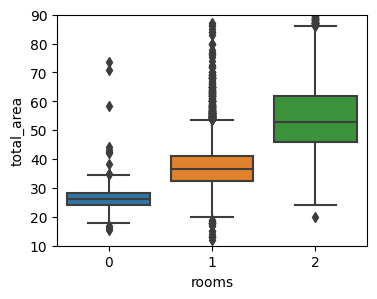

In [52]:
#диаграммы размаха площадей "нуля-", одна- и двухкомнатных квартир
plt.figure(figsize=(4,3)); plt.ylim(10,90)
sbn.boxplot(x='rooms',y='total_area',data=data.query('rooms in [0,1,2]'))
plt.show()

Квартиры с "нулём" комнат близки по площади к однокомнатным квартирам.\
Заменим 0 на 1 у объектов с площадью до 3-его квартиля однокомнатных квартир, до 41 кв.м.\
Оставшиеся несколько нулевух значений удалим.

In [53]:
# кол-во "нолькомнатных" квартир с площадью меньше 41 и больше
data.query('rooms == 0').apply(lambda x: 'area <= 41' if x['total_area']<41 else 'area > 41',axis=1).value_counts()             

area <= 41    188
area > 41       9
dtype: int64

In [54]:
data.loc[(data['rooms'] == 0) & (data['total_area']<=41),'rooms'] = 1   # задаём одну комнату, где общая площадь меньше 41
data.loc[(data['rooms'] == 0),'rooms'] = float('NaN')                   # удаляем значения, где об.пл. больше 41

In [55]:
data[['total_area','rooms']].query('~rooms.isna()').sort_values('rooms').tail() #5 объектов с максимальным числом комнат

,total_area,rooms
20829,245.4,14.0
866,363.0,14.0
5358,590.0,15.0
18848,270.0,16.0
14498,374.6,19.0


Максимальное кол-во комнат сопаставимо с общей площадью. Выбросов нет.

**living_area** - подозрительно маленькое минимальное значение; проверим крайние значения.

In [56]:
data[['total_area','living_area','kitchen_area']].sort_values('living_area').head(10) # 10 объектов с минимальной жил.площадью

,total_area,living_area,kitchen_area
13915,52.0,2.0,9.0
21758,23.0,2.0,0.0
3242,41.0,3.0,11.0
23574,139.0,3.0,16.0
17582,22.0,5.0,0.0
21943,77.6,5.4,9.8
16431,31.0,6.0,17.0
19251,33.0,6.5,18.0
23208,37.0,8.0,22.0
20994,50.6,8.0,31.0


Вероятно, жилая площадь первых шести объектов (кроме 17582) в 10 раз меньше реальной. Исправим:

In [57]:
data.loc[data['living_area'].isin([2,3,5.4]),'living_area'] = data.loc[data['living_area'].isin([2,3,5.4]),'living_area']*10

In [58]:
# 5 объектов с максимальной жил.площадью
data[['total_area','living_area','kitchen_area']].query('~living_area.isna()').sort_values('living_area').tail() 

,total_area,living_area,kitchen_area
3676,441.98,406.93,35.05
5358,590.00,409.00,100.00
19540,900.00,409.70,112.00
5893,500.00,460.00,40.00
3117,631.00,571.00,60.00


Выбросов в большую сторону у жилой площади нет.

**kitchen_area** - минимального выброса быть не может, так как допустим даже "ноль" (например, в студии); проверим наличие выбросов в бОльшую сторону.

In [59]:
# 5 объектов с максимальной кухонной площадью
data[['total_area','living_area','kitchen_area']].query('~kitchen_area.isna()').sort_values('kitchen_area').tail()

,total_area,living_area,kitchen_area
5631,280.0,160.0,120.0
11436,316.3,187.0,129.3
155,317.0,183.0,134.0
12971,400.0,250.0,150.0
7674,380.0,150.0,230.0


Выбросов по кухонной площади нет.

**first_day_exposition**

In [60]:
data.describe(include='datetime',datetime_is_numeric=True) #описание столбца с датой размещения объявления

,first_day_exposition
count,23698
mean,2017-11-08 21:39:38.023461888
min,2014-11-27 00:00:00
25%,2017-05-12 06:00:00
50%,2017-12-12 00:00:00
75%,2018-08-26 00:00:00
max,2019-05-03 00:00:00


В столбце с датой выбросов нет.

In [61]:
#кол-ва пропусков до и после двух обработок (2-ая из подраздела 2.3., где добавляли пропуски в вместо странных значений)
#вывод только изменившихся характеристик
data_nan_after2 = \
 (pd.DataFrame(data.isna().sum(), columns=['sum_nun_after2']).join                             # сумма пропущенных значений
 (pd.DataFrame(data.isna().apply(lambda x: round(x.mean()*100)),columns=['%_nun_after2'])))   # % пропущенных значений

data_nan_before.join([data_nan_after1,data_nan_after2]).query('(sum_nun_before != sum_nun_after1) | \
                                                               (sum_nun_after1 != sum_nun_after2)')

,sum_nun_before,%_nun_before,sum_nun_after1,%_nun_after1,sum_nun_after2,%_nun_after2
rooms,0.0,0.0,0,0,9,0
ceiling_height,9195.0,39.0,9195,39,9200,39
living_area,1903.0,8.0,1454,6,1454,6
kitchen_area,2278.0,10.0,1454,6,1454,6
balcony,11519.0,49.0,0,0,0,0
airports_nearest,5542.0,23.0,4922,21,4922,21
cityCenters_nearest,5519.0,23.0,4899,21,4899,21
parks_around3000,5518.0,23.0,4898,21,4898,21
ponds_around3000,5518.0,23.0,4898,21,4898,21


In [62]:
#сумма и средний процент пропусков в исходном df и после двух обработок
#изменение сумм и процента пропусков после каждой обработки
dn = data_nan_before.join([data_nan_after1,data_nan_after2]).\
                                          agg({'sum_nun_before':'sum','sum_nun_after1':'sum','sum_nun_after2':'sum'})
print(f"кол-во пропусков после 1-ой обработки уменьшилось на \
{dn['sum_nun_before']-dn['sum_nun_after1']:.0f} шт. и {(dn['sum_nun_before']-dn['sum_nun_after1'])/dn['sum_nun_before']:.0%}")
print(f"кол-во пропусков после 2-ой обработки уменьшилось на \
{dn['sum_nun_before']-dn['sum_nun_after2']:.0f} шт. и {(dn['sum_nun_before']-dn['sum_nun_after2'])/dn['sum_nun_before']:.0%}\
    (сравнение с исходным df)")

кол-во пропусков после 1-ой обработки уменьшилось на 15272 шт. и 15%
кол-во пропусков после 2-ой обработки уменьшилось на 15258 шт. и 15%    (сравнение с исходным df)


**Вывод:**
* уменьшил количество пропусков в исходном df на 15%;
* столбец с датой размещения объявления преобразовал из строчного формата в datetime (потребуется далее для вычленения элементов);
* диапазон высот потолков от 1 до 100 м привёл к 2-8.3 м (удалил 3 значения слишком низких потолков (<2м), 2 значения слишком высоких (20-30м), 1 весь объект с высотой потолка 100м; 22 значения высоты (20-32м) уменьшил в 10 раз);
* цену 1 объекта увеличил в 3 раза (до 12 млн.р.), приведя до близости к медианному значению стоимости объектов схожей площади;
* из 197 "нолькомнатных" квартир сделал 188 однокомнатных и у 9-ти удалил кол-во комнат (на основе анализа площадей одно- и двухкомнатных квартир);
* жилую площадь у 5-ти объектов (2-5.4 кв.м) увеличил в 10 раз до сопоставимых значений с общей площадью.

## Расчёт и добавление в таблицу новых столбцов <a id='3.'></a>

In [63]:
# новые столбцы (цена за кв.м, день недели, месяц, год, расстояние до центра города в км)
data['price_m']                = data['last_price']/data['total_area']
data['weekday']                = data['first_day_exposition'].dt.weekday
data['month']                  = data['first_day_exposition'].dt.month
data['year']                   = data['first_day_exposition'].dt.year
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)

In [64]:
def floor_type(i):
    if i['floor'] == 1:
        return 'first'
    elif i['floor'] == i['floors_total']:
        return 'last'
    elif i.isna()['floors_total']:
        return float('NaN')
    else:
        return 'other'
data['floor_type']     = data.apply(floor_type,axis=1)                       # новый столбец с типом этажа (first, last, other)
data['floor_type_num'] = data['floor_type'].map({'first':1,'last':2,'other':3}) # новый столбец с типом этажа (числовой)

## Исследовательский анализ данных

In [65]:
data.describe() #описание числовых характерист (после обработки редких и выбивающихся значений)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,weekday,month,year,cityCenters_nearest_km,floor_type_num
count,23698.000000,2.369800e+04,23698.000000,23689.000000,14498.000000,23612.000000,22244.000000,23698.000000,22244.000000,23698.000000,18776.000000,18799.000000,18800.000000,8078.000000,18800.000000,9109.000000,20517.000000,2.369800e+04,23698.000000,23698.000000,23698.000000,18799.000000,23615.00000
mean,9.858891,6.541706e+06,60.350143,2.079404,2.728099,10.674064,34.912758,5.892396,10.804362,0.590894,29546.891111,14465.218682,0.591330,490.837707,0.807500,518.034471,180.896525,9.940525e+04,2.569331,6.400076,2017.367120,14.462365,2.61173
std,5.682288,1.088708e+07,35.654096,1.066191,0.292487,6.597209,23.109409,4.885349,6.849240,0.958891,13092.220776,8609.753989,0.796329,342.326214,0.947708,277.688812,219.730436,5.019857e+04,1.789116,3.491632,1.039785,8.620386,0.69612
min,0.000000,4.300000e+05,12.000000,1.000000,2.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,7.962963e+03,0.000000,1.000000,2014.000000,0.000000,1.00000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.800000,2.000000,7.000000,0.000000,18771.000000,9464.000000,0.000000,288.000000,0.000000,294.000000,45.000000,7.659305e+04,1.000000,3.000000,2017.000000,9.000000,2.00000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.040000,4.000000,9.200000,0.000000,27285.500000,13279.000000,0.000000,455.000000,1.000000,502.000000,95.000000,9.500000e+04,3.000000,6.000000,2017.000000,13.000000,3.00000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.800000,8.000000,12.000000,1.000000,38817.000000,16787.000000,1.000000,612.000000,1.000000,729.000000,232.000000,1.142519e+05,4.000000,10.000000,2018.000000,17.000000,3.00000
max,50.000000,7.630000e+08,900.000000,19.000000,8.300000,60.000000,571.000000,33.000000,230.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000,3.00000


### Изучение характеристик

#### total_area, living_area, kitchen_area

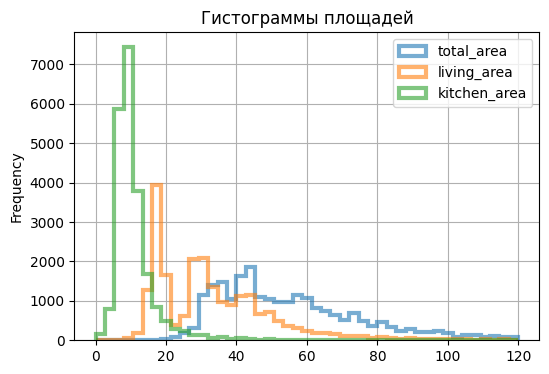

In [66]:
data.plot(kind='hist',y=['total_area','living_area','kitchen_area'],bins=45,
          range=(0,120),histtype='step',alpha=0.6,linewidth=3,grid=True,
          figsize=(6,4),title='Гистограммы площадей'); plt.show()

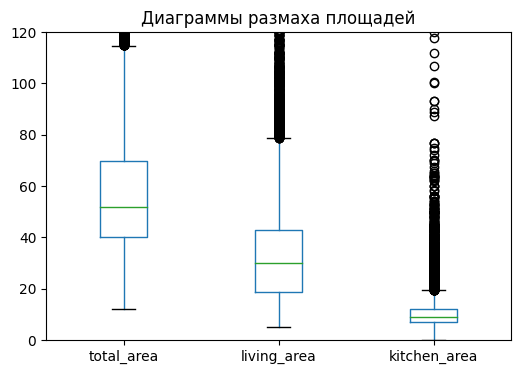

In [67]:
data.plot(kind='box',y=['total_area','living_area','kitchen_area'],ylim=(0,120),
          figsize=(6,4),title='Диаграммы размаха площадей'); plt.show()

* Гистограммы площадных характеристик скошены вправо. Так как площадь на прямую коррелируется со стоимостью объека и с уровнем дохода владельца подобное распределение свидетельствует о высокой поляризациии общества - львиная доля бедных и немного богатых.
* Так как общая площадь является суммой жилой площади и кухонной, график общей площади сдвинут правее относительно остальных.
* У гистограммы жилой площади два пика на 18 и 32 м2; между ними впадина на 23 м2. Возможно, связано с наиболее массовыми типовыми одна- и двухкомнатными квартирами, средняя жилая площадь которых соответствует двум пикам. Проверим.

In [68]:
data[['rooms','living_area']].groupby('rooms').agg(['mean','count']).head() #средняя жил. пл. в зависимости от кол-ва комнат 

living_area      
             mean count
rooms                  
1.0     18.139929  7709
2.0     32.115009  7461
3.0     48.015598  5475
4.0     67.989034  1108
5.0    100.877826   299

Предположение о причинах двух пиков жилой площади подтвердилось. \
Диаграммы размаха ожидаемого вида. Визуально оцениваем реперные значения - медианы, квартили, диапазон статистически значимой выборки. 

#### rooms

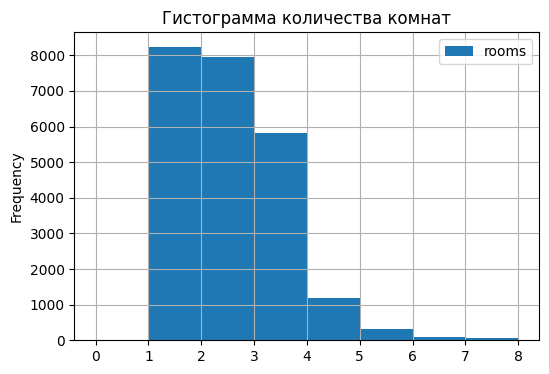

In [69]:
data.plot(kind='hist',y='rooms',bins=8, range=(0,8), grid=True,figsize=(6,4),title='Гистограмма количества комнат'); plt.show()

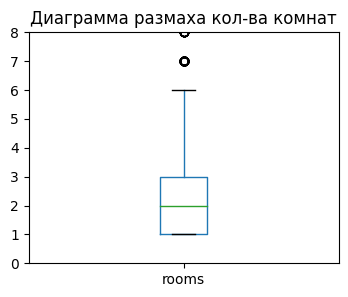

In [70]:
data.plot(kind='box',y='rooms',ylim=(0,8),figsize=(4,3),title='Диаграмма размаха кол-ва комнат'); plt.show()

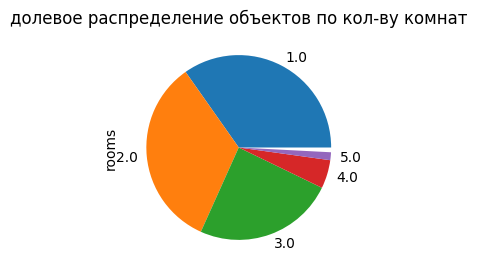

In [71]:
data['rooms'].value_counts(normalize=True).head().plot(kind='pie',figsize=(3,3),
                                                       title='долевое распределение объектов по кол-ву комнат',
                                                       normalize=False); plt.show()

Одна-,двух- и трёхкомнатные квартиры занимают 94% рынка. Оставшиеся 6% - от 4 до 19 комнатные квартиры; по необходимости и по возможности.

#### last_price

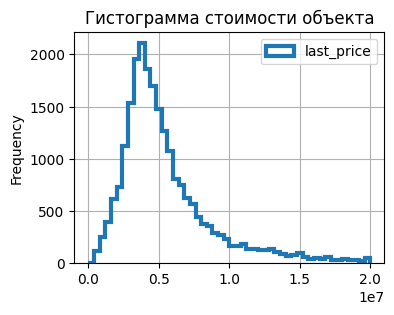

In [72]:
data.plot(kind='hist',y='last_price',bins=50,range=(0,20000000),histtype='step',linewidth=3,grid=True,
          figsize=(4,3),title='Гистограмма стоимости объекта'); plt.show()

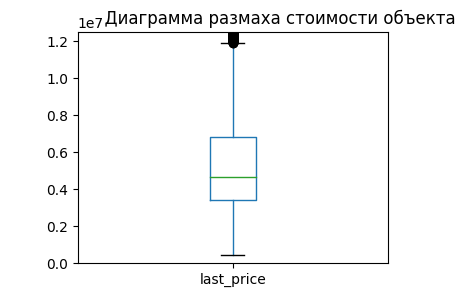

In [73]:
data.plot(kind='box',y='last_price',ylim=(0,12500000),figsize=(4,3),
          title='                  Диаграмма размаха стоимости объекта'); plt.show()

Гистограмма стоимости имеет черты распределения Пуассона. Но, в диапазоне 1-10 млн. распределение носит нормалный характер.

#### ceiling_height

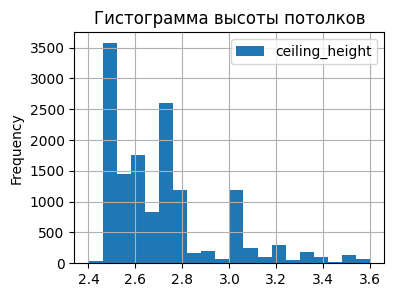

In [74]:
data.plot(kind='hist',y='ceiling_height',bins=20,range=(2.4,3.6),grid=True,
          figsize=(4,3),title='Гистограмма высоты потолков'); plt.show()

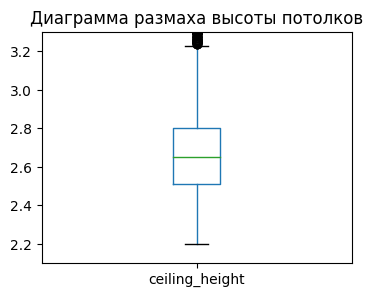

In [75]:
data.plot(kind='box',y='ceiling_height',ylim=(2.1,3.3),figsize=(4,3),
          title='Диаграмма размаха высоты потолков'); plt.show()

Гистограмма является не плавной. Ступенчатая, скочкообразная. Вероятно, связано с нормами строительства, регламентирующими определённые высоты. Распределение ненормальное скошенное вправо.

#### floor, floors_total

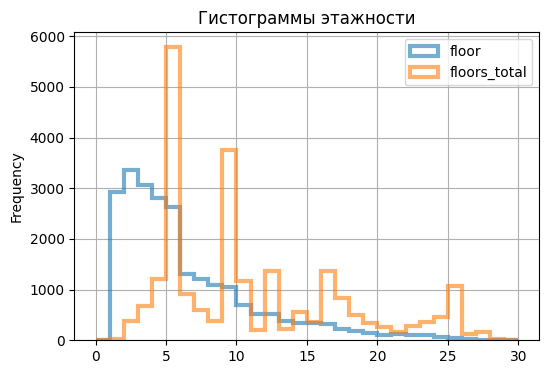

In [76]:
data.plot(kind='hist',y=['floor','floors_total'],bins=30,
          range=(0,30),histtype='step',alpha=0.6,linewidth=3,grid=True,figsize=(6,4),title='Гистограммы этажности'); plt.show()

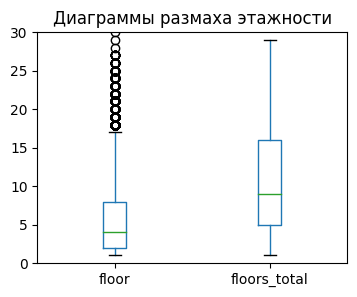

In [77]:
data.plot(kind='box',y=['floor','floors_total'],ylim=(0,30),
          figsize=(4,3),title='Диаграммы размаха этажности'); plt.show()

В гистограмме этажности общего количества этажей явно вырожены несколько пиков - самые распространённые типовые многоэтажки: "хрущёвки" (5), 9-ти, 16-ти и 25-ти этажные дома. Видимо "хрущёвок" и девятиэтажек в жилищном фонде СПБ больше всего. \
От сюда следует логичный вывод, что чаще всего будет выставлен на продажу 2 и 3 этажи (5/2 - пик нормального распределения). Это подтверждается гистограммой этажности объектов.

#### floor_type

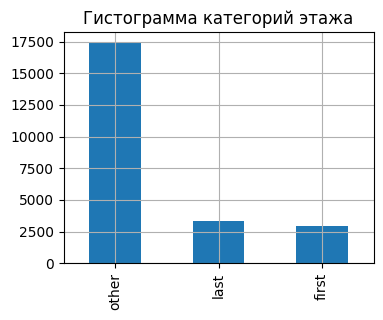

In [78]:
data['floor_type'].value_counts().plot(kind='bar',grid=True, figsize=(4,3),title='Гистограмма категорий этажа'); plt.show()

In [79]:
data['floor_type'].value_counts(normalize=True) #долевое распределение этажных категорий

other    0.735253
last     0.141224
first    0.123523
Name: floor_type, dtype: float64

Крайние этажи обычно менее востребованы и дешевле (по опыту).

#### airports_nearest,	cityCenters_nearest

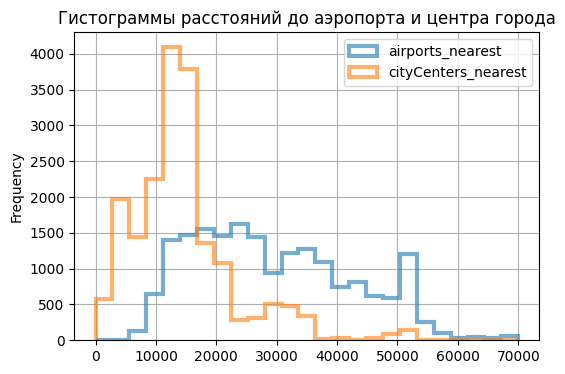

In [80]:
data.plot(kind='hist',y=['airports_nearest','cityCenters_nearest'],bins=25, range=(0,70000),
          histtype='step',alpha=0.6,linewidth=3,grid=True,figsize=(6,4),
          title='Гистограммы расстояний до аэропорта и центра города'); plt.show()

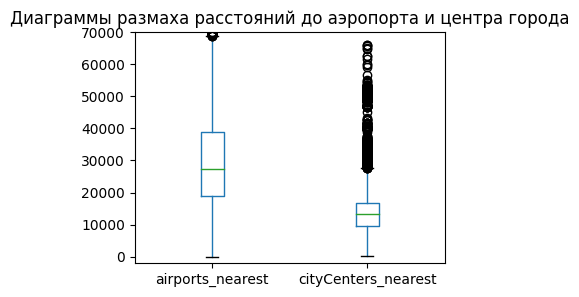

In [81]:
data.plot(kind='box',y=['airports_nearest','cityCenters_nearest'], ylim=(-2000,70000),
          figsize=(4,3),title='Диаграммы размаха расстояний до аэропорта и центра города'); plt.show()

Наиболее часто встречаемое расстояние до центра города около 13 км. Она же медиана. Это соответствует общепринятому пониманию расстояния от центра до спальных районов.\
Расстояние до аэропорта в среднем больше, чем до центра города и имеет большое стандартное отклонение. На гистограмме относительно продолжительный диапазон без явных пиков.

#### parks_nearest, ponds_nearest

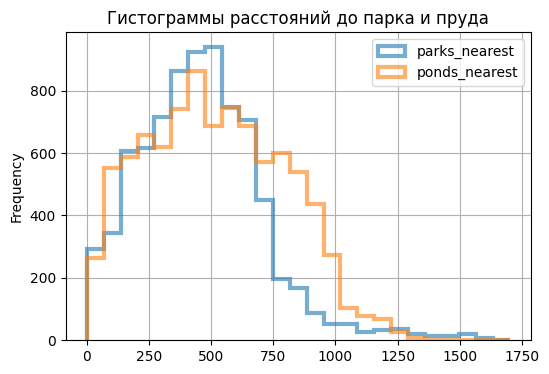

In [82]:
data.plot(kind='hist',y=['parks_nearest', 'ponds_nearest'],bins=25, range=(0,1700),
          histtype='step',alpha=0.6,linewidth=3,grid=True,figsize=(6,4),
          title='Гистограммы расстояний до парка и пруда'); plt.show()

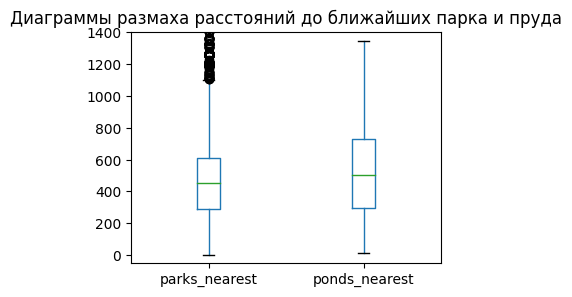

In [83]:
data.plot(kind='box',y=['parks_nearest', 'ponds_nearest'], ylim=(-50,1400),
          figsize=(4,3),title='Диаграммы размаха расстояний до ближайших парка и пруда'); plt.show()

Графики гистограммы почти идентичны друг другу. Это приводит к гениальной и неожиданной мысли, что пруд обычно в парке 😸\
Но есть участок в диапазоне от 700 до 1100 м, где ближайших прудов значительно больше нежели парков. СПБ построен на болотах. Много различных водоёмов и они не обязательно находятся в парках.

#### first_day_exposition

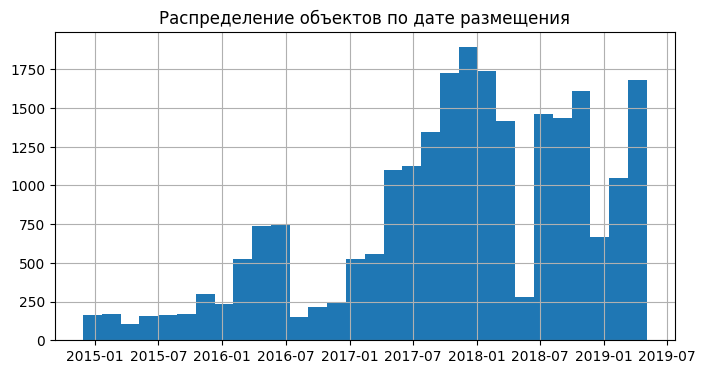

In [84]:
data['first_day_exposition'].hist(bins=30, figsize=(8,4)).set_title('Распределение объектов по дате размещения')
plt.show()

#### weekday

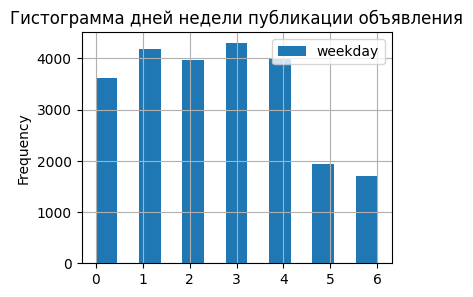

In [85]:
data.plot(kind='hist',y='weekday',bins=13,grid=True,figsize=(4,3),title='Гистограмма дней недели публикации объявления')
plt.show()

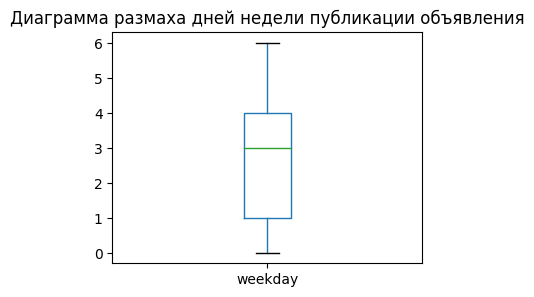

In [86]:
data.plot(kind='box',y='weekday',figsize=(4,3),title='Диаграмма размаха дней недели публикации объявления'); plt.show()

Чаще всего размещают объявления со вторника по пятницу. Вероятно, чаще публикуют агенства по недвижимости, соблюдающие трудовой кодекс и реже работающие на выходных.

#### month

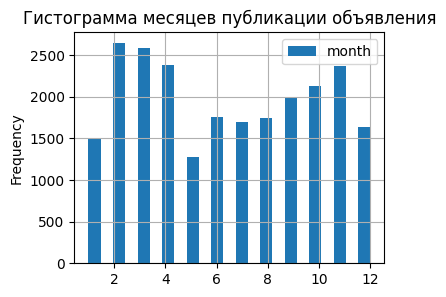

In [87]:
data.plot(kind='hist',y='month',bins=23,grid=True,figsize=(4,3),title='Гистограмма месяцев публикации объявления'); plt.show()

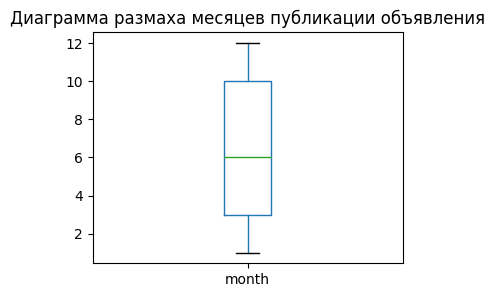

In [88]:
data.plot(kind='box',y='month',figsize=(4,3),title='Диаграмма размаха месяцев публикации объявления'); plt.show()

Чаще всего объявления публикуются в стандартные месяцы наибольшей деловой активности. Т.е. все кроме летнего периода отпусков и новогодних праздников.

#### days_exposition

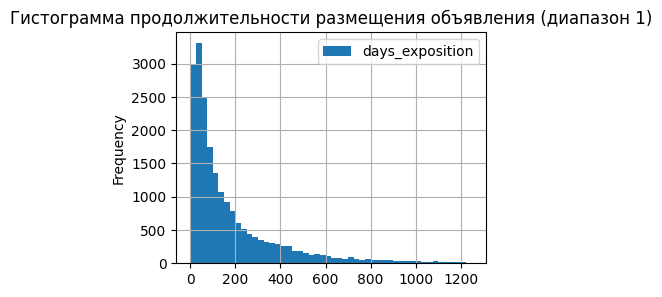

In [89]:
data.plot(kind='hist',y='days_exposition',bins=50,grid=True,figsize=(4,3),range=(0,1250),
          title='Гистограмма продолжительности размещения объявления (диапазон 1)'); plt.show()

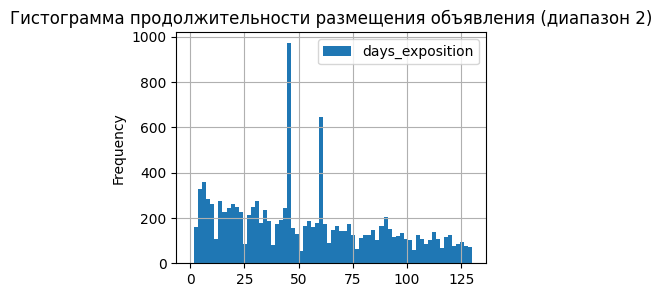

In [90]:
data.plot(kind='hist',y='days_exposition',bins=70,grid=True,figsize=(4,3),range=(0,130),
          title='Гистограмма продолжительности размещения объявления (диапазон 2)'); plt.show()

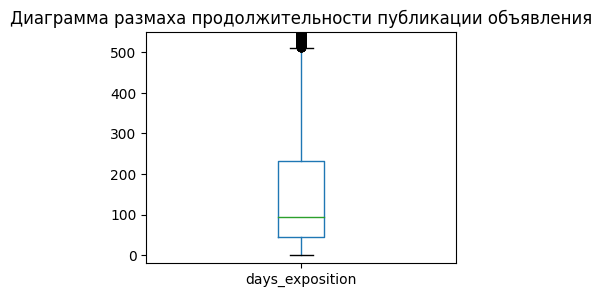

In [91]:
data.plot(kind='box',y='days_exposition',figsize=(4,3),ylim=(-20,550),
          title='Диаграмма размаха продолжительности публикации объявления'); plt.show()

Гистограмма ненормального типа, скошена вправо. Рассмотрим более частотную часть гистограммы в диапазоне 0-130 дней. Видим пики в районе 45, 60, 90 дней. Вероятно, это реперные точки после которых владелец снижает цену при отсутствии продажи - месяц, два, три. Покупатель, увидев, что цена упала, или просто, заметив новый объект в желаемом диапазоне цен, торопится совершить сделку. <br><br>
Медиана - 95. Среднее - 181. Большая разница связана с длинным "хвостом" гистограммы, уходящем вправо. Много выбросов. Объясняется отсутствием острой необходимости скорейшей продажи объекта. Владельцы не торопятся, прицениваются, держат высокую цену. Ждут своего покупателя, которому будет нужен именно этот объект пусть даже по цене выше среднерыночной. \
Обычно продажа занимает от 45 до 232 дней (первый, третий квартили). <br><br>
Скорость продажи - понятие относительное. Чёткого определения нет. Зависит от потребности продавца, какой он для себя установил оптимальный срок. Но, если большой директор 🧔 в нашей аналитической компании требует составление регламентного документа с указанием "слишком-точек", за данные точки можно условно принять первый и третий квартили:
- быстрые продажи - до 45 дней;
- необычно долгие продажи - после 232 дней.

### Факторы влияющие на общую стоимость объекта

### Диаграммы рассеяния

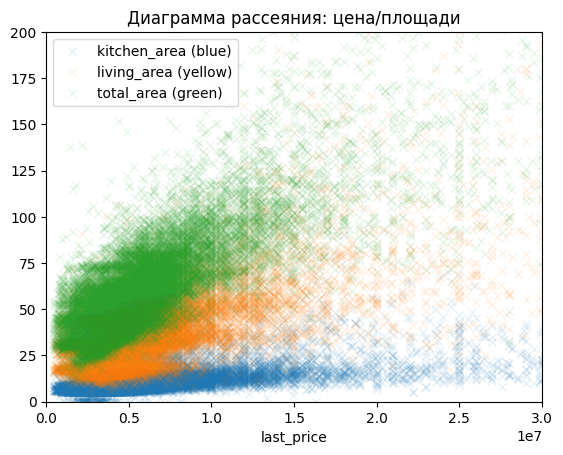

In [92]:
data.plot(x='last_price',y=['kitchen_area','living_area','total_area'],style='x',alpha=0.1,xlim=(0,3*10**7),ylim=(0,200),
          title='Диаграмма рассеяния: цена/площади', label=['kitchen_area (blue)','living_area (yellow)','total_area (green)'])
plt.show()

Наблюдается положительная зависимость.

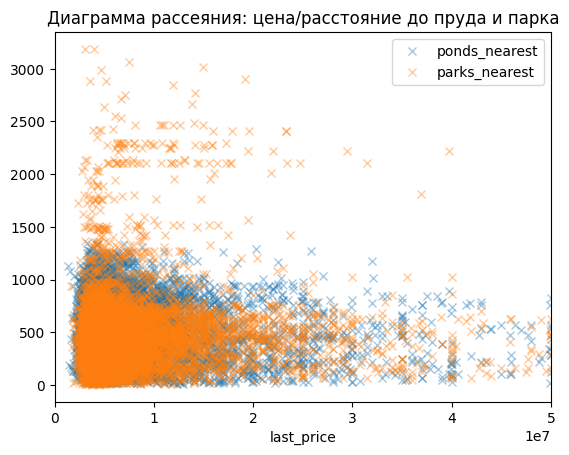

In [93]:
data.plot(x='last_price',y=['ponds_nearest','parks_nearest'],style='x',alpha=0.4,
          title='Диаграмма рассеяния: цена/расстояние до пруда и парка', xlim=(0,50*10**6))
plt.show()

Наблюдается отрицательная зависимость. Количественная оценка ниже в подразделе с расчётами коэффициентов корреляции.

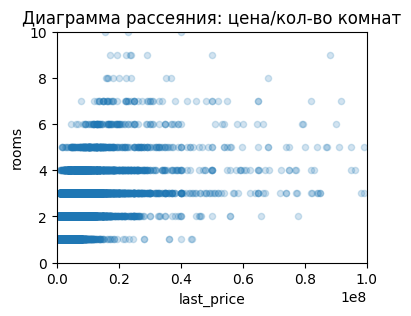

In [94]:
data.plot(kind='scatter', x='last_price',y='rooms',alpha=0.2,xlim=(0,10**8),ylim=(0,10),figsize=(4,3),
          title='Диаграмма рассеяния: цена/кол-во комнат'); plt.show()

Наблюдается положительная зависимость.

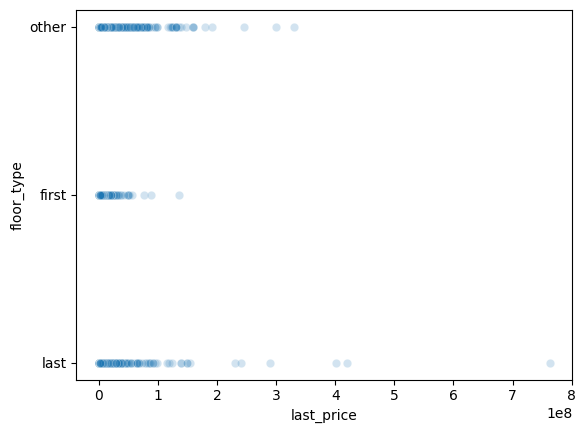

In [95]:
# Диаграмма рассеяния: цена / категория этажа
# использую seaborb, т.к. не разобрался как обычными инструментами построить д.рассеяния с нечисловыми характеристиками
sbn.scatterplot(x=data['last_price'],y=data['floor_type'],alpha=0.2); plt.show()

Наблюдается небольшая корреляция. Количество первых этажей с большей ценой меньше относительно двух других категорий.

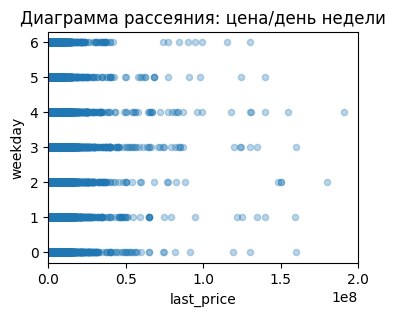

In [96]:
data.plot(kind='scatter', x='last_price',y='weekday', alpha=0.3, xlim=(0,2*10**8), figsize=(4,3),
          title='Диаграмма рассеяния: цена/день недели'); plt.show()

Зависимости почти нет. Совсем немного выделяются четверг с пятницей для более дорогих сделок. В воскресенье люди не любят принимать дорогостоящие решения. Да, и конторы для оформления сделок не работают.

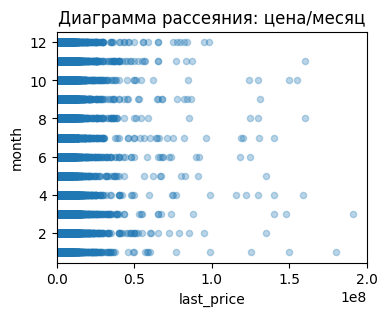

In [97]:
data.plot(kind='scatter', x='last_price',y='month', alpha=0.3, xlim=(0,2*10**8), figsize=(4,3),
          title='Диаграмма рассеяния: цена/месяц'); plt.show()

Зависимости нет.

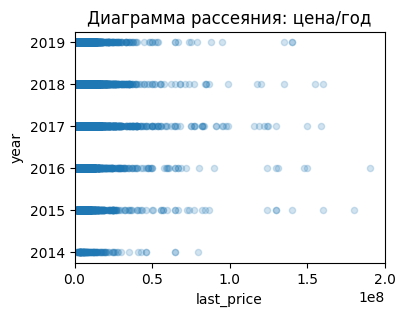

In [98]:
data.plot(kind='scatter', x='last_price',y='year', alpha=0.2, xlim=(0,2*10**8), figsize=(4,3),
          title='Диаграмма рассеяния: цена/год'); plt.show()

Небольшая зависимость наблюдается. С 2014 до 2017 виден рост количества более дорогих сделок. После 2017 - спад.

Рассмотрим динамику медианных значений общей площади, цены объекта, стоимости квадрадратного метра, а также количества сделок в год.

In [99]:
#сводная таблица, сгруппированная по годам, содержащая медианы и количества 
pivot_year_area_price = data[['total_area','last_price','year','price_m']].groupby('year').median().\
                        join(pd.DataFrame(data[['year','floor']]).groupby('year').count())
pivot_year_area_price.columns = ['total_area','last_price','price_m','count'] #корректировка имени последнего столбца
pivot_year_area_price

,total_area,last_price,price_m,count
year,,,,
2014,76.26,7700000.0,107000.000000,137
2015,60.00,5350000.0,93414.634146,1191
2016,53.10,4550000.0,91743.119266,2783
2017,52.00,4500000.0,92565.088448,8190
2018,50.50,4550000.0,95688.493354,8518
2019,52.00,5050000.0,103351.955307,2879


Количества в крайних годах подозрительно выбивается из плавной закономерности.

In [100]:
# количество конкретных месяцев в срезе 2014 года
data.query('year == 2014')['month'].value_counts()

12    117
11     20
Name: month, dtype: int64

In [101]:
# количество конкретных месяцев в срезе 2019 года
data.query('year == 2019')['month'].value_counts()

4    956
3    879
2    557
1    426
5     61
Name: month, dtype: int64

Удалим крайние годы из сводной таблицы, так как в 2014 году учтён фактически только 1 месяц, а в 2019-ом - 4 месяца. Медианные годовые значения могут быть недостоверными.

In [102]:
pivot_year_area_price = pivot_year_area_price.loc[2015:2018] # удаление строк

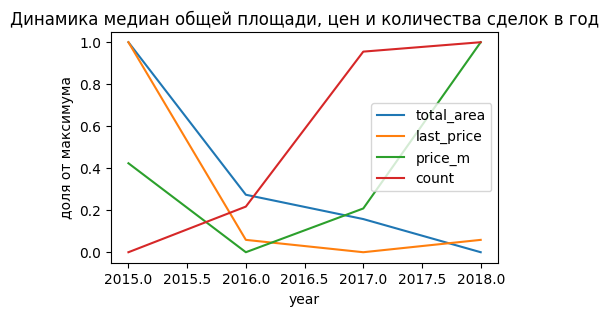

In [103]:
pivot_year_area_price.apply(lambda x: (x-x.min())/(x.max()-x.min())).plot(figsize=(5,3),
          title='Динамика медиан общей площади, цен и количества сделок в год',ylabel='доля от максимума'); plt.show()

Полная стоимость объекта и площадь отрицательно коррелируют с течением времени. \
Удельная цена за кв.м. падает до 2016 года, после возрастает. \
График относительный, поэтому размер корреляции не ясен. Коэффициенты корреляции определяются в следующем подразделе.

### Коэффициенты корреляции Пирсона

На значение коэффициента влияет срез данных, сделанный по определённому диапазону стоимости объектов. \
Сделаем 2 типа расчёта:
1) диапазоны от нуля до реперных точек (от 0 до 100 млн. интервал в 1 млн., далее от 100 до 800 млн. интервал 100 млн.); \
2) диапазоны между реперными точками (0-3, 3-10, 10-20, 20-40, 40-100, 100-800 млн.); \
\
Таким образом, мы увидим взаимосвязь данных, как на всём интервале цены (1-ый расчёт), так и на отдельных участках (2-ой расчёт).

In [104]:
def f_corr_df(lim_price_min,lim_price_max):
    '''ф-ия формирует df c одной строкой - значениями к.к.П. между ценой и другими характеристиками; 
    имена колонок  - характеристики data; индекс - макс.знач.диапазона 'last_price', по которому делаем срез из data; 
    на входе - границы диапазона'''
        
    df_corr = pd.DataFrame(data.query('@lim_price_min<=last_price<=@lim_price_max').corr()['last_price']
                           [['total_area','living_area','kitchen_area','rooms','weekday', 'month', 'year',
                             'ponds_nearest','parks_nearest', 'floor_type_num']])
    df_corr.columns = [lim_price_max]
    return df_corr.T

**Коэффициент корреляции (1-ый тип расчёта)**

In [105]:
#формируем df со значениями к.к.П; колонки - характеристики; индексы - диапазон цены (0-max), по кот. получены значения
corr_df1=pd.DataFrame()
for max in list(range(10**6,10**8+1,10**6))+list(range(2*10**8,7*10**8+1,10**8))+[763*10**6]:
    corr_df1 = pd.concat([corr_df1, f_corr_df(0,max)])

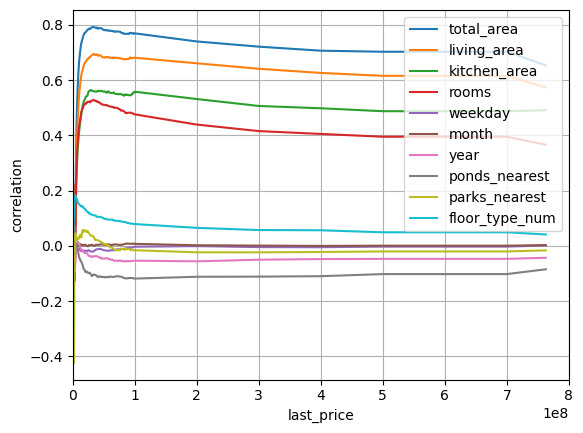

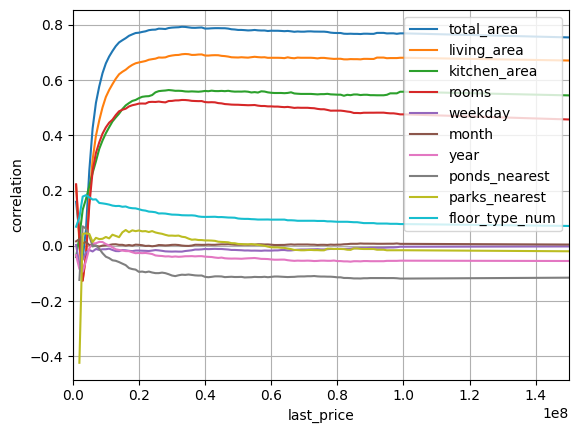

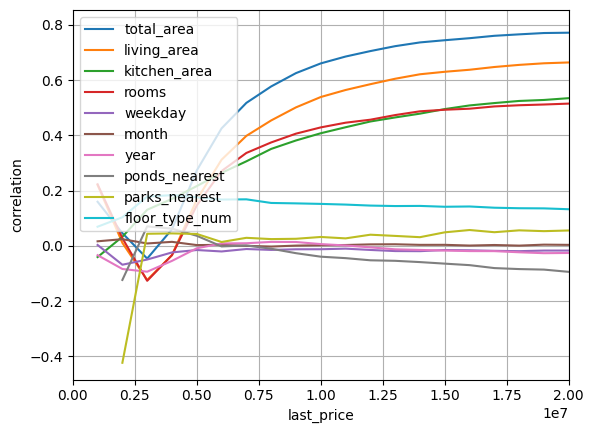

In [106]:
corr_df1.plot(xlim=(0,800*10**6),grid=True, xlabel='last_price', ylabel='correlation') #мастаб оси x: 0 - 800 млн.
corr_df1.plot(xlim=(0,150*10**6),grid=True, xlabel='last_price', ylabel='correlation') #мастаб оси x: 0 - 150 млн.
corr_df1.plot(xlim=(0,20*10**6),grid=True,  xlabel='last_price', ylabel='correlation') #мастаб оси x: 0 -  20 млн.
plt.show()

Вывод по 1-ому типу расчёта к.корреляции.\
Есть зависимость стоимости объекта от площадных характеристик и количества комнат:
- общая площадь - высокая зависимость (более 11 млн.); средняя (от 6 до 11 млн);
- жилая площадь - средняя зависимость (выше 8 млн.);
- кухонная площади и кол-во комнат - средняя зависимость (выше 17 млн.).
<br>

Цена очень слабо зависит от дня недели, месяца, года, типа этажа, расстояние до ближайших парков и прудов.

**Коэффициент корреляции (2-ой тип расчёта)**

In [107]:
#формируем df со значениями к.к.П; колонки - характеристики; индексы - диапазон цены (min-max), по кот. получены значения
corr_df2=pd.DataFrame()
for min,max in [(0,3),(3,10),(10,20),(20,40),(40,100),(100,800)]:
    corr_df2 = pd.concat([corr_df2, f_corr_df(min*10**6,max*10**6)])

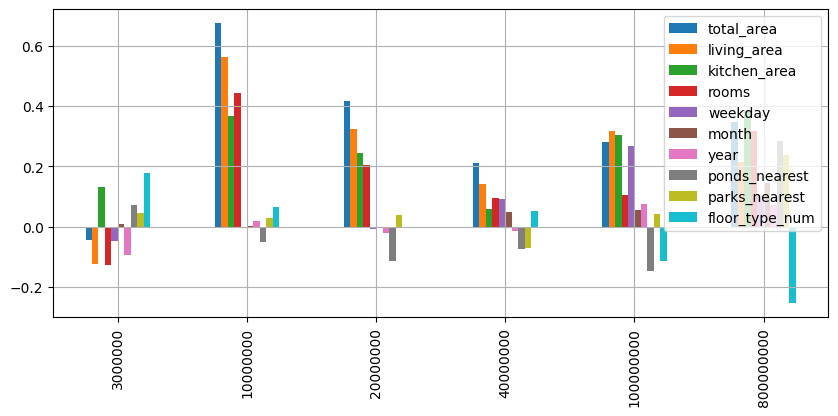

In [108]:
corr_df2.plot(kind='bar',figsize=(10,4),grid=True); plt.show()

In [109]:
for min,max in [(0,3),(3,10),(10,20),(20,40),(40,100),(100,800)]: #кол-во объектов в каждом ценовом диапазоне
    print(f"от {min} до {max} млн. - {data.query('@min*10**6<last_price<=@max*10**6').shape[0]} объектов")

от 0 до 3 млн. - 4166 объектов
от 3 до 10 млн. - 16811 объектов
от 10 до 20 млн. - 2014 объектов
от 20 до 40 млн. - 525 объектов
от 40 до 100 млн. - 145 объектов
от 100 до 800 млн. - 37 объектов


Вывод по 2-ому типу расчёта к.корреляции.\
Наибольшая зависимость цены от почти всех характеристик наблюдается в диапазоне 3-10 млн. руб. Обратим внимание, что именно на этом участке наибольшее кол-во объектов. Тем не менее, по логике, не должно быть прямой зависимости между кол-ом объектов и величиной корреляции характеристик. Можно сказать, что кол-во объектов определяет качество проведённого статистического исследования. 
На этом диапазоне цена имеет среднюю зависимость от общей и жилой площали, и слабую зависимость от количества комнат и кухонной площади.\
Заметим очень слабую корреляцию в 1-ом (0-3 млн.) и 4-ом (20-40 млн.) диапазонах. Сложно сказать о причинах.

### Населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [110]:
# средняя цена и медиана одного кв.м. в 10 населённых пунктах с наибольшим числом объявлений
loc_name_price = data.groupby('locality_name_short')['price_m'].agg(['count','mean','median'])
loc_name_price.sort_values('count',ascending=False).head(10)

,count,mean,median
locality_name_short,,,
Санкт-Петербург,15720,114825.253834,104766.085539
Мурино,590,86087.512050,86175.643522
Кудрово,472,95324.930544,95675.473579
Шушары,440,78677.364217,76876.172608
Всеволожск,398,68654.473986,65789.473684
Пушкин,369,103125.819291,100000.000000
Колпино,338,75424.579098,74723.748474
Парголово,327,90175.913458,91642.857143
Гатчина,307,68746.146763,67796.610169


In [111]:
# населённые пункты с самой высокой стоимостью кв. м (по среднему значению)
loc_name_price.sort_values('mean',ascending=False).head()

,count,mean,median
locality_name_short,,,
Зеленогорск,24,115122.799198,101666.666667
Санкт-Петербург,15720,114825.253834,104766.085539
Репино,4,104238.614786,86542.207792
Пушкин,369,103125.819291,100000.000000
Сестрорецк,183,101757.616875,99678.456592


In [112]:
# населённые пункты с самой высокой стоимостью кв. м (по медиане)
loc_name_price.sort_values('median',ascending=False).head()

,count,mean,median
locality_name_short,,,
Санкт-Петербург,15720,114825.253834,104766.085539
Зеленогорск,24,115122.799198,101666.666667
Пушкин,369,103125.819291,100000.000000
Сестрорецк,183,101757.616875,99678.456592
Левашово,1,96997.690531,96997.690531


In [113]:
# населённые пункты с самой низкой стоимостью кв. м (по среднему значению)
loc_name_price.sort_values('mean').head()

,count,mean,median
locality_name_short,,,
Старополье,3,11206.221198,11000.000000
Свирь,2,11481.481481,11481.481481
Вахнова Кара,1,11688.311688,11688.311688
Выскатка,2,12335.480902,12335.480902
Совхозный,2,12629.129129,12629.129129


In [114]:
# населённые пункты с самой низкой стоимостью кв. м (по медиане)
loc_name_price.sort_values('median').head()

,count,mean,median
locality_name_short,,,
Старополье,3,11206.221198,11000.000000
Свирь,2,11481.481481,11481.481481
Вахнова Кара,1,11688.311688,11688.311688
Выскатка,2,12335.480902,12335.480902
Совхозный,2,12629.129129,12629.129129


### Зависимость стоимости объектов от расстояния до центра города в Санкт-Петербурге

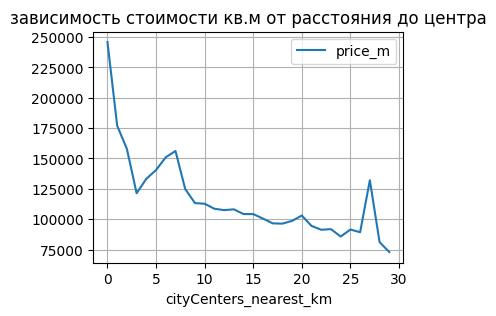

In [115]:
spb_price = data.loc[data['locality_name_short'] == 'Санкт-Петербург',['cityCenters_nearest_km','price_m']]
spb_price.pivot_table(index = 'cityCenters_nearest_km',values='price_m',aggfunc='mean').\
                      plot(figsize=(4,3),title='зависимость стоимости кв.м от расстояния до центра',grid=True); plt.show()

In [116]:
# к-нт корреляции Пирсона между ценой кв.м и расстоянием до центра города СПБ
spb_price['cityCenters_nearest_km'].corr(spb_price['price_m'])

-0.31489519698768376

Зависимость стоимости квадратного метра от расстояния до центра визуально видна и является слабой отрицательной.
Наблюдаются пики в районе 7-ого и 27-ого км. Это могут буть престижные районы, например, Пушкин, Павловск, Петергоф.

## Общий вывод

В рамках поставленной задачи по определению уровня влияния характеристик объектов недвижимости на стоимость этих объектов проведена следующая работа и получены результаты.
1. **Предобработаны исходные данные:**\
уменьшено количество пропусков в исходном датафрейме на 15%; столбец с датой размещения объявления преобразован из строчного формата в datetime; диапазон высот потолков от 1 до 100 м приведён к 2-8.3 м; из 197 "нолькомнатных" квартир сделаны 188 однокомнатных и у 9-ти удалил кол-во комнат; жилая площадь у 5-ти объектов увеличена в 10 раз.
2. **В целях удобства последующего анализа рассчитаны и добавлены в таблицу новые столбцы:** стоимость квадратного метра, день недели, месяц, год, расстояние до центра в километрах, тип этажа (первый, последний, другой).
3. **Исследовательский анализ данных.**\
Выявленные особенности: <br> 
одна-,двух- и трёхкомнатные квартиры занимают 94% рынка; \
стоимость большинства объектов в интервале 3,4-6,8 млн. руб.; \
объявления чаще публикуются со втоника по пятницу в основные месяцы деловой активности (февраль-апрель, сентябрь-ноябрь); \
типовой срок продажи от 45 до 232 дней.
<br>

Зависимость полной стоимости объекта от факторов.
- Высокая: общая площадь.
- Средняя: жилая и кухонные площади, количество комнат.
- Очень слабая: день недели, месяц, год, тип этажа, расстояние до ближайших парков и прудов.
<br>\
Зависимость стоимости квадратного метра от расстояния до центра Санкт-Петербурга - слабая отрицательная.
<br>
Наибольшая зависимость цены от почти всех характеристик наблюдается в диапазоне 3-10 млн. руб.
<br>
Населённые пункты с самой высокой стоимостью квадратного метра: Санкт-Петербург, Зеленогорск, Пушкин, Сестрорецк.
4. **Рекомендации**.
Для более эффективной оценки стоимости недвижимости желательно также обладать следующими параметрами: точный адрес, социальная инфраструктура (школы, садики, больницы), экологическая обстановка (ближайшие промзоны, уровень загрязнения воздуха), криминогенность района, близость к метро, плотность застройки, наличие парковочных мест, год постройки.

